In [4]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [5]:
%load_ext autoreload
%autoreload 2
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import get_class_from_class_path, HELMConverter
from node import MolSentenceNode #change after Filter implementation
from generator import MCTS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
config_path = "config/mcts_helm.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class_path, model_dir, lang_class_path, lang_path = (conf.get(k) for k in ("model_class_path", "model_dir", "lang_class_path", "lang_path"))
lang_class = get_class_from_class_path(lang_class_path)
lang = lang_class.load(repo_root + lang_path)
if lang_class_path.endswith("HELM"): #should be removed after .lang inclusion
    lang.converter = HELMConverter().load(repo_root + "data/helm/library/chembl_35_monomer_library.xml")
model_class = get_class_from_class_path(model_class_path)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class_path, reward_conf = (conf.get(k) for k in ("reward_class_path", "reward_conf"))
reward_class = get_class_from_class_path(reward_class_path)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class_path", "policy_conf"))
policy_class = get_class_from_class_path(policy_class_path)
policy = policy_class(**policy_conf)

Search is started.
0- time: 0.21, count_rollouts: 1, reward: -0.11005540524909564, mol: PEPTIDE1{D.R.V.Y.I.H.P.F}$$$$
1- time: 0.35, count_rollouts: 2, reward: -0.16644293195439402, mol: PEPTIDE1{K.Q.W.Q.N.W.W.R.W.P.R.W.[am]}$$$$
2- time: 0.55, count_rollouts: 4, reward: -0.3364934903075694, mol: PEPTIDE1{R.P.[dK].[dP].[dQ].[dQ].F.F.G.L.M.[am]}$$$$
3- time: 0.79, count_rollouts: 7, reward: -0.8026780526655841, mol: PEPTIDE1{F.G.G.F.T.G.A.R.K.S.A.R.K.L.A.N.Q}$$$$
4- time: 0.88, count_rollouts: 8, reward: -0.5751420968756846, mol: PEPTIDE1{A.E.L.A.A.L.A.A.E.L.A.A.L.E.G.S.W.L.V.W.R.K.L.L.G.K.L.A.A.L.K.A.K.L.A.A.L.K.A}$$$$
5- time: 1.13, count_rollouts: 10, reward: -0.01745122811268444, mol: PEPTIDE1{K.R.F.W.K}$$$$
6- time: 1.16, count_rollouts: 11, reward: -0.024011383842834626, mol: PEPTIDE1{L.I.K.R.G.R.V.W.W}$$$$
7- time: 1.21, count_rollouts: 12, reward: -0.15959394424064413, mol: PEPTIDE1{S.Q.L.F.P}$$$$
8- time: 1.63, count_rollouts: 15, reward: -0.3364934903075694, mol: PEPTIDE1{[dR]

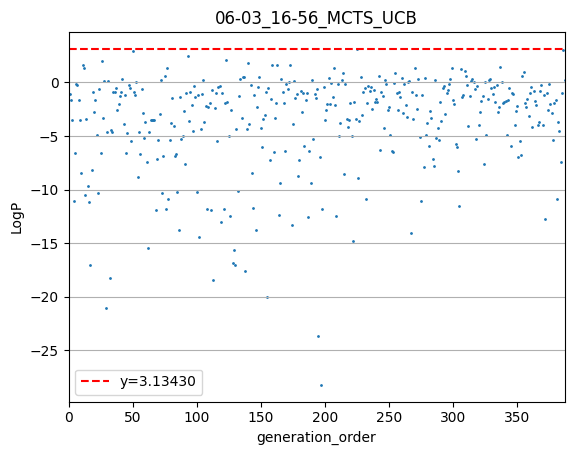

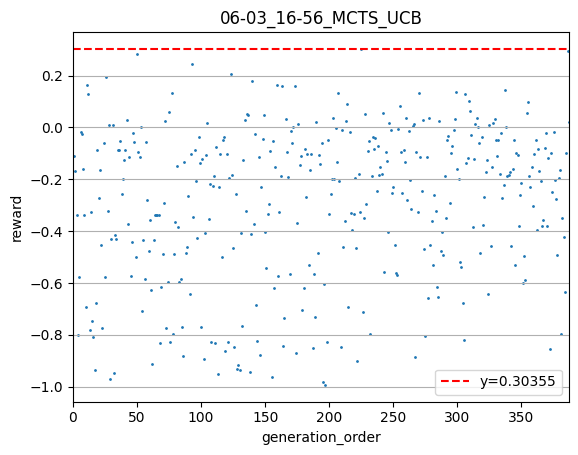

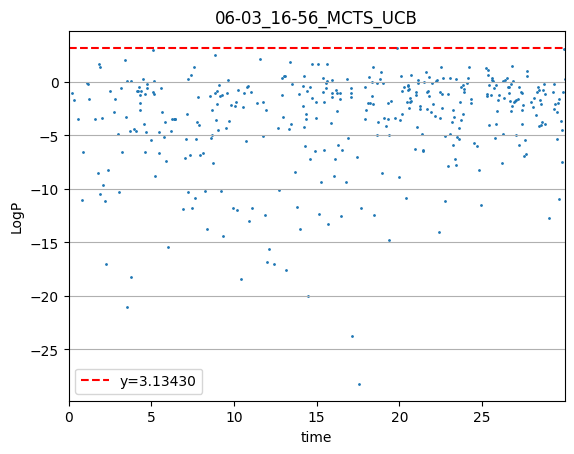

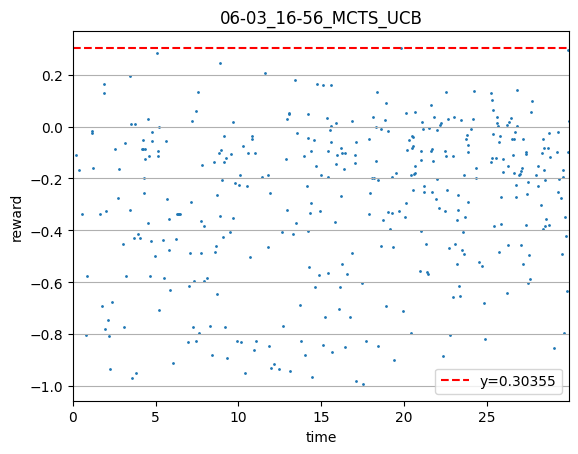

Search is completed.


In [7]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang)

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, output_dir=output_dir)
generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)